<div style="display:flex">
    <img src="https://bse.eu/sites/default/files/bse_logo_small.png" alt="Logo 1">
</div>

# Traffic Signs Detection

## Table of Contents
1. **[Part 1: Data preparation](#part1)**
   - 1.1. Loading and Exploring Data
   - 1.2. Image and Label Structure 
   - 1.3. Class Distribution Analysis

2. **[Part 2: Few-Shot Classification](#part2)**
   - 2.1 Few-Shot Dataset Creation
   - 2.2 Model 1: No Augmentation
   - 2.3 Model 2: Augmentation
   - 2.4 Model 3: Augmentation + Focal Loss

   


### Install and Import libraries

In [ ]:
!pip install ultralytics

In [ ]:
# Importing Libraries
import os
import shutil
import random
import pandas as pd
from PIL import Image
import cv2
from ultralytics import YOLO
from IPython.display import Video
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')
import pathlib
import glob
from tqdm.notebook import trange, tqdm
import warnings
warnings.filterwarnings('ignore')

# Setting the random seed for reproducibility
random.seed(42)
np.random.seed(42)

## Part 1: Data Preparation <a id="part1"></a>

To investigate the dataset, we will first check that there are no mismatches between images and labels, then understand how the labelling system works and how its paired to the images, and visualize some examples.  Additionally, we can check the classes distribution

### Utilities functions

In [3]:
# Function to display an image with its bounding boxes
def display_image_with_boxes(image_path, label_file, include_label=True):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Read the label file
    with open(label_file, 'r') as file:
        labels = file.readlines()

    # Draw bounding boxes on the image
    for label in labels:
        parts = label.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])
        
        # Convert YOLO format to pixel coordinates
        img_height, img_width, _ = image.shape
        x1 = int((x_center - width / 2) * img_width)
        y1 = int((y_center - height / 2) * img_height)
        x2 = int((x_center + width / 2) * img_width)
        y2 = int((y_center + height / 2) * img_height)

        # Draw rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        # Put class ID text
        if include_label:
            cv2.putText(image, class_names[str(class_id)], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show() 

In [4]:
# Function to get the label file path from the image path
def get_label_file(image_path):
    # Replace 'images' with 'labels' in the path
    label_path = image_path.replace('images', 'labels').replace('.jpg', '.txt')
    return label_path

In [5]:
# Set the directory paths
path= os.getcwd()
Image_dir = os.path.join(path, 'data', 'train', 'images')
image_files = os.listdir(Image_dir)

Understand how labels are structured and paired with images

Labels for FisheyeCamera_1_00076_png.rf.c1649fd1ef9e95ffa77a31dcffb825ed.jpg:
0 0.3641826923076923 0.41346153846153844 0.015625 0.009615384615384616
7 0.36778846153846156 0.5456730769230769 0.006009615384615385 0.008413461538461538
1 0.4495192307692308 0.5024038461538461 0.006009615384615385 0.003605769230769231


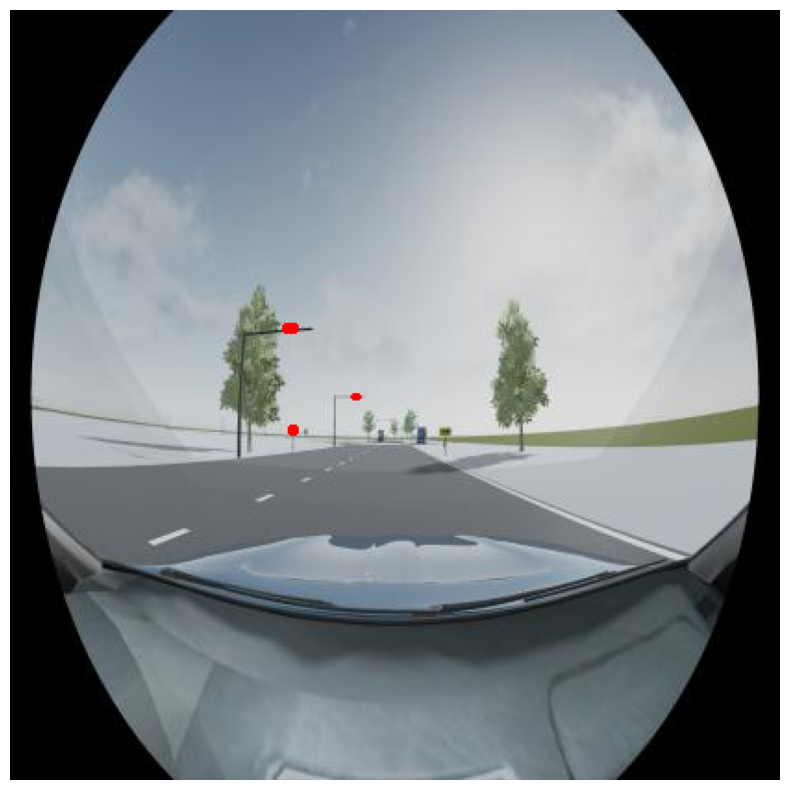

In [6]:
# Get a random image and its corresponding label file
random_image_path = os.path.join(Image_dir, random.choice(image_files))
label_file = get_label_file(random_image_path)

# Read the label file
if os.path.exists(label_file):
    with open(label_file, 'r') as file:
        labels = file.readlines()
    print(f"Labels for {os.path.basename(random_image_path)}:")
    for label in labels:
        print(label.strip())
else:
    print(f"No label file found for {os.path.basename(random_image_path)}")
# Display a random image with its bounding boxes

display_image_with_boxes(random_image_path, label_file, include_label=False)


As we can observe, labels are not in natural languange, but rather encoded in an intengers list. Let's further investigate on that, and create a dictionary the class numbers (6) to natural language labels (speed limit 20), using the information on the kaggle dataset

In [7]:
# get a set of all image labels (only the number of the class)
labels = set()
for image in image_files:
    label_file = get_label_file(os.path.join(Image_dir, image))
    if os.path.exists(label_file):
        with open(label_file, 'r') as file:
            for line in file:
                class_id = line.strip().split()[0]
                labels.add(class_id)

# Convert the set to a sorted list
labels = sorted(labels)
# Display the unique labels
print(f"Unique labels found in the dataset: {labels}")


Unique labels found in the dataset: ['0', '1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7', '8', '9']


In [8]:
# create a dictionary to map class IDs to class names
class_names = {
    '0': 'Green Light',
    '1': 'Red Light',
    '2': 'Speed Limit 10',  
    '3': 'Speed Limit 100',
    '4': 'Speed Limit 110',
    '5': 'Speed Limit 120',
    '6': 'Speed Limit 20',
    '7': 'Speed Limit 30',
    '8': 'Speed Limit 40',
    '9': 'Speed Limit 50',
    '10': 'Speed Limit 60',
    '11': 'Speed Limit 70',
    '12': 'Speed Limit 80',
    '13': 'Speed Limit 90',
    '14': 'Stop'}

Let's now verify that these label names are correct (we can re run the following code chunk multiple times to assert this)

Labels for 00002_00017_00008_png.rf.958d92ad47742185bf2850483fb42da9.jpg:
9 0.5120192307692307 0.4795673076923077 0.6177884615384616 0.6430288461538461


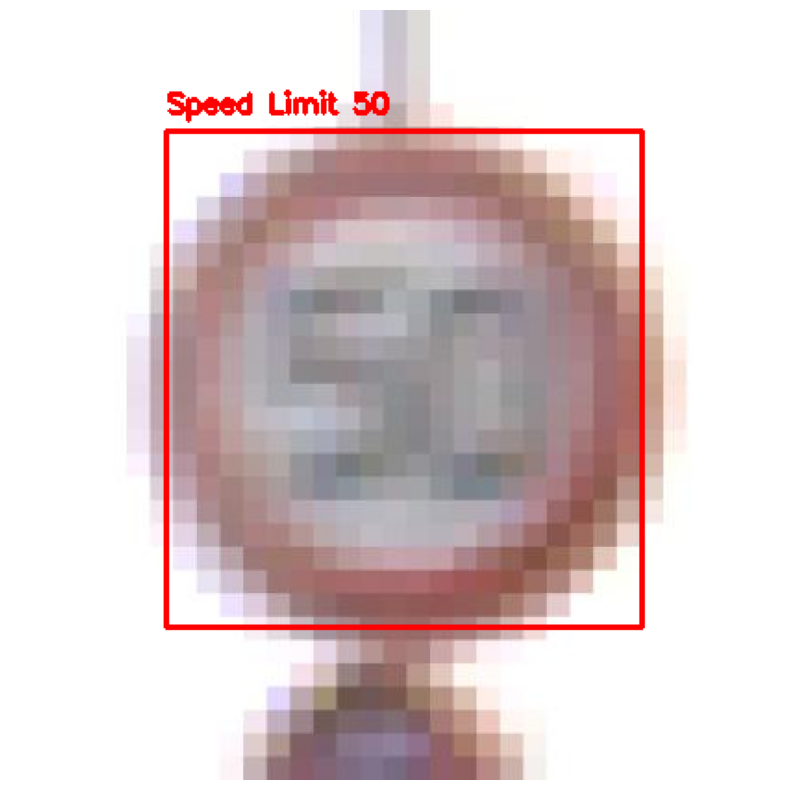

In [9]:
# Get a random image and its corresponding label file
random_image_path = os.path.join(Image_dir, random.choice(image_files))
label_file = get_label_file(random_image_path)

# Read the label file
if os.path.exists(label_file):
    with open(label_file, 'r') as file:
        labels = file.readlines()
    print(f"Labels for {os.path.basename(random_image_path)}:")
    for label in labels:
        print(label.strip())
else:
    print(f"No label file found for {os.path.basename(random_image_path)}")


# Display a random image with its bounding boxes
display_image_with_boxes(random_image_path, label_file)

Look for mismatches

In [ ]:
# Count total amount of train, val and test images (+ labels)
train_images = os.listdir(Image_dir)
train_labels = os.listdir(os.path.join(path, 'data', 'train', 'labels'))
print(f'Total number of training images: {len(train_images)}')
print(f'Total number of training labels: {len(train_labels)}\n')

val_images = os.listdir(os.path.join(path, 'data', 'valid', 'images'))
val_labels = os.listdir(os.path.join(path, 'data', 'valid', 'labels'))
print(f'Total number of validation images: {len(val_images)}')    
print(f'Total number of validation labels: {len(val_labels)}\n')   

test_images = os.listdir(os.path.join(path, 'data', 'test', 'images'))
test_labels = os.listdir(os.path.join(path, 'data', 'test', 'labels'))
print(f'Total number of test images: {len(test_images)}')
print(f'Total number of test labels: {len(test_labels)}')

Total number of training images: 3530
Total number of training labels: 3530

Total number of validation images: 801
Total number of validation labels: 801

Total number of test images: 638
Total number of test labels: 638


Check Image shape

In [11]:
# Get the size of a random image
random_image_path = os.path.join(Image_dir, random.choice(image_files))

# Load the image
image = cv2.imread(random_image_path)

# Get the size of the image
h, w, c = image.shape
print(f"The image has dimensions {w}x{h} and {c} channels.")

The image has dimensions 416x416 and 3 channels.


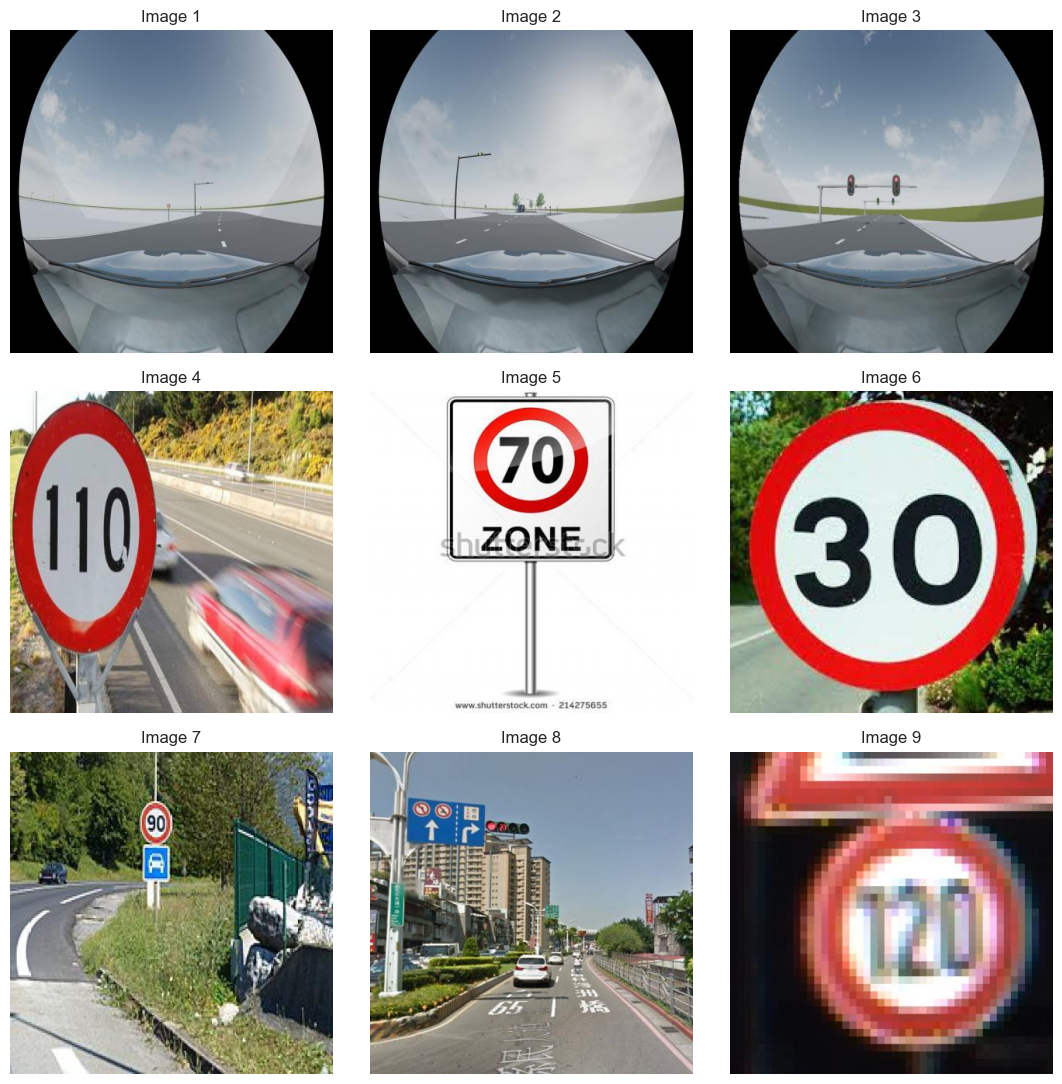

In [46]:
num_samples = 9

# Randomly select num_samples images
rand_images = random.sample(image_files, num_samples)

fig, axes = plt.subplots(3, 3, figsize=(11, 11))

for i in range(num_samples):
    image = rand_images[i]
    ax = axes[i // 3, i % 3]
    ax.imshow(plt.imread(os.path.join(Image_dir, image)))
    ax.set_title(f'Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Looking good! Now we have a pretty good idea of how the images are structured. Let's look at the image distribution before we can move on to training end evaluating our models 

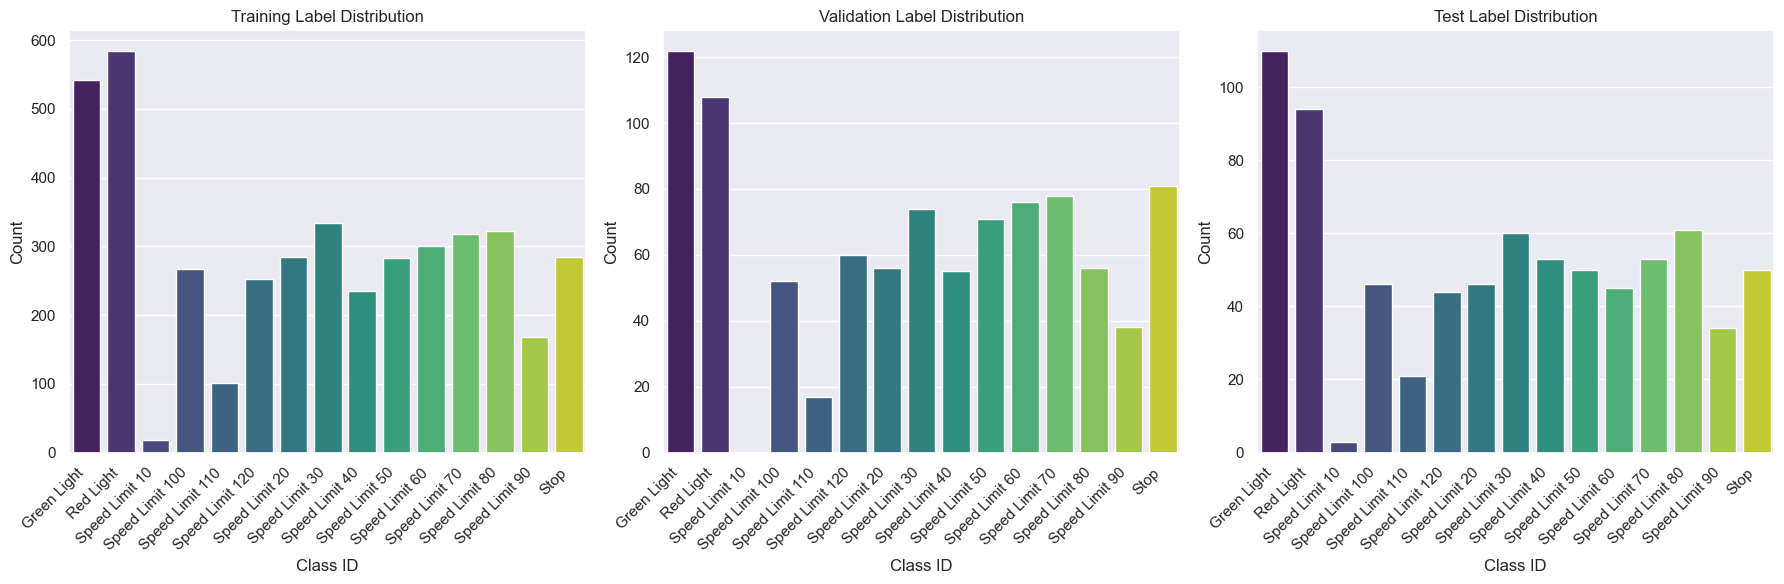

In [12]:

# train
train_label_counts = {label: 0 for label in class_names.values()} 
for label_file in train_labels:
    with open(os.path.join(path, 'data', 'train', 'labels', label_file), 'r') as file:
        for line in file:
            class_id = class_names[line.strip().split()[0]]
            train_label_counts[class_id] += 1
# Convert to DataFrame for easier plotting
train_label_counts_df = pd.DataFrame(list(train_label_counts.items()), columns=['Class ID', 'Count'])

# Validation
val_label_counts = {label: 0 for label in class_names.values()}
for label_file in val_labels:
    with open(os.path.join(path, 'data', 'valid', 'labels', label_file), 'r') as file:
        for line in file:
            class_id = class_names[line.strip().split()[0]]
            val_label_counts[class_id] += 1
# Convert to DataFrame for easier plotting
val_label_counts_df = pd.DataFrame(list(val_label_counts.items()), columns=['Class ID', 'Count'])   

# Test
test_label_counts = {label: 0 for label in class_names.values()}
for label_file in test_labels:
    with open(os.path.join(path, 'data', 'test', 'labels', label_file), 'r') as file:
        for line in file:
            class_id = class_names[line.strip().split()[0]]
            test_label_counts[class_id] += 1
# Convert to DataFrame for easier plotting
test_label_counts_df = pd.DataFrame(list(test_label_counts.items()), columns=['Class ID', 'Count'])


# Create three subplots for train, validation, and test label distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, df, title in zip(axes,
                         [train_label_counts_df, val_label_counts_df, test_label_counts_df],
                         ['Training', 'Validation', 'Test']):
    sns.barplot(x='Class ID', y='Count', data=df, ax=ax, palette='viridis')
    ax.set_title(f'{title} Label Distribution')
    ax.set_xlabel('Class ID')
    ax.set_ylabel('Count')
    # rotate the labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

We can observe some very dispare class distribution, yet there is some sort of consistency across the different datasets (train, val, test). Below are a few considerations:
- Given the extreme class imbalance of Speed Limit 10, we decide to drop it. We will however keep Speed Limit 110 as it is a significantly imbalanced class which can perhaps help deliver a valuable Error Analysis later. 
- To tackle the class imbalance, we could **switch the classification head to Focal Loss**, which is a provided option for YOLOv8. 
- It is also interesting to allow for class-specific confidence thresholds at inference time, to further account for the class imbalance. 

100%|██████████| 6.25M/6.25M [00:04<00:00, 1.49MB/s]



0: 640x640 (no detections), 9.9ms
Speed: 5.1ms preprocess, 9.9ms inference, 21.6ms postprocess per image at shape (1, 3, 640, 640)


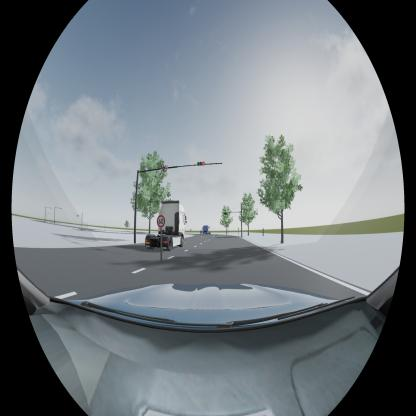

In [ ]:
# load the pretrained YOLOv8n model
model = YOLO("yolov8n.pt") 

# Use the model to detect object

# Build the image path using os.path.join
image_path = os.path.join( Image_dir,
    'FisheyeCamera_1_00228_png.rf.e7c43ee9b922f7b2327b8a00ccf46a4c.jpg'
)

image = cv2.imread(image_path)
result_predict = model.predict(source = image, imgsz=(640))

# show results
plot = result_predict[0].plot()
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))

## Training the model on this customized dataset <a id="part2"></a>

In [ ]:
# !pip install --upgrade ultralytics ray

### 2.1 Few-Shot Dataset Creation

Explain how we do it

In [15]:
# Define paths again
Image_dir = os.path.join(path, 'data', 'train', 'images')
train_labels = os.listdir(os.path.join(path, 'data', 'train', 'labels'))


# Create a new directory for the few-shot dataset
few_shot_data_dir = os.path.join(path, 'data', 'few_shot')
few_shot_img_dir  = os.path.join(few_shot_data_dir, 'images')
few_shot_lbl_dir  = os.path.join(few_shot_data_dir, 'labels')
os.makedirs(few_shot_img_dir, exist_ok=True)
os.makedirs(few_shot_lbl_dir, exist_ok=True)


# Function to copy a specified number of images for each class
def copy_few_shot_images(class_id, num_images):
    
    matching = []
    for lf in train_labels:
        lbl_path = os.path.join(path, 'data', 'train', 'labels', lf)
        with open(lbl_path) as f:       
            lines = [line.strip() for line in f if line.strip()] # Read and strip out any blank lines            
            if lines and all(line.split()[0] == class_id for line in lines):
                matching.append(lf) # Keep only files that have at least one box, and all boxes are of this class

    if len(matching) < num_images:
        print(f"Not enough for class {class_id}: found {len(matching)}")
        return

    for lf in random.sample(matching, num_images):
        img_name = lf.replace('.txt', '.jpg')
        shutil.copy(
            os.path.join(Image_dir, img_name),
            os.path.join(few_shot_img_dir, img_name)
        )
        shutil.copy(
            os.path.join(path, 'data', 'train', 'labels', lf),
            os.path.join(few_shot_lbl_dir, lf)
        )

# copy 10 examples per class, skipping '2'
for class_id in class_names.keys():
    if class_id != '2':
        copy_few_shot_images(class_id, 10)

print("Total few-shot images:", len(os.listdir(few_shot_img_dir)))

Total few-shot images: 140


In [ ]:
# Build from YAML and transfer weights
Final_model = YOLO('yolov8n.pt')  

# Training The Final Model
Result_Final_model = Final_model.train(data=os.path.join(os.getcwd(),"data", "data.yaml"),epochs = 10, batch = -1, optimizer = 'auto')

Ultralytics 8.3.151  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\data\data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto,

100%|██████████| 755k/755k [00:01<00:00, 765kB/s] 
2025-06-06 11:15:59,600	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:05<00:00, 1.09MB/s]


AMP: checks passed 
train: Fast image access  (ping: 0.20.1 ms, read: 1.90.6 MB/s, size: 24.1 KB)


train: Scanning C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\data\train\labels... 3530 images, 3 backgrounds, 0 corrupt: 100%|██████████| 3530/3530 [00:11<00:00, 295.05it/s]


train: New cache created: C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\data\train\labels.cache
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU) 4.00G total, 0.11G reserved, 0.08G allocated, 3.81G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3013773       8.209         0.405            54           580        (1, 3, 640, 640)                    list
     3013773       16.42         0.545            56           192        (2, 3, 640, 640)                    list
     3013773       32.84         0.866            41         162.2        (4, 3, 640, 640)                    list
     3013773       65.67         1.420            47         148.4        (8, 3, 640, 640)                    list
     3013773       131.3         2.485         64.53         164.4       (16, 3, 640, 640)           

train: Scanning C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\data\train\labels.cache... 3530 images, 3 backgrounds, 0 corrupt: 100%|██████████| 3530/3530 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.20.1 ms, read: 1.20.6 MB/s, size: 19.9 KB)


val: Scanning C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\data\valid\labels... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:02<00:00, 289.62it/s]


val: New cache created: C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\data\valid\labels.cache
Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00046875), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train2
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10       1.6G     0.8625      4.027      1.216          2        640: 100%|██████████| 295/295 [00:49<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:06<00:00,  5.36it/s]


                   all        801        944      0.265      0.473      0.309      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.83G     0.7709      2.945       1.09          2        640: 100%|██████████| 295/295 [00:44<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  5.75it/s]

                   all        801        944      0.511      0.525      0.507      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.83G     0.7374      2.313      1.066          3        640: 100%|██████████| 295/295 [00:44<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  5.68it/s]

                   all        801        944      0.629      0.591      0.666      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.83G      0.704      1.804      1.049          2        640: 100%|██████████| 295/295 [00:43<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  5.74it/s]

                   all        801        944      0.827      0.676      0.786      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.83G     0.6822      1.397       1.02          4        640: 100%|██████████| 295/295 [00:44<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  5.85it/s]

                   all        801        944      0.861      0.712      0.828      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.83G     0.6418      1.182     0.9958          3        640: 100%|██████████| 295/295 [00:44<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:06<00:00,  5.47it/s]

                   all        801        944      0.894      0.754      0.861      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.83G     0.6214      1.011     0.9813          5        640: 100%|██████████| 295/295 [00:44<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:06<00:00,  5.58it/s]

                   all        801        944      0.905      0.791      0.885      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.83G     0.5992     0.8987     0.9683          2        640: 100%|██████████| 295/295 [00:43<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:06<00:00,  5.35it/s]

                   all        801        944      0.913      0.824      0.902      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.83G     0.5802     0.8182     0.9582          3        640: 100%|██████████| 295/295 [00:44<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:06<00:00,  5.66it/s]

                   all        801        944      0.927      0.807      0.911       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.83G     0.5508     0.7486     0.9426          2        640: 100%|██████████| 295/295 [00:44<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:06<00:00,  5.65it/s]

                   all        801        944       0.93      0.843       0.92      0.788



10 epochs completed in 0.149 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 6.2MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics 8.3.151  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:06<00:00,  5.27it/s]


                   all        801        944      0.931      0.842       0.92      0.788
           Green Light         87        122      0.829      0.715      0.779      0.441
             Red Light         74        108      0.772      0.753      0.762      0.431
       Speed Limit 100         52         52      0.803      0.904      0.935      0.861
       Speed Limit 110         17         17          1      0.791      0.956      0.848
       Speed Limit 120         60         60      0.981      0.859      0.965      0.879
        Speed Limit 20         56         56      0.986      0.893      0.976      0.851
        Speed Limit 30         71         74      0.978      0.959       0.97      0.898
        Speed Limit 40         53         55      0.943      0.909      0.968      0.855
        Speed Limit 50         68         71      0.948      0.803      0.927      0.834
        Speed Limit 60         76         76      0.944      0.886      0.951      0.862
        Speed Limit 7

## Model Validation

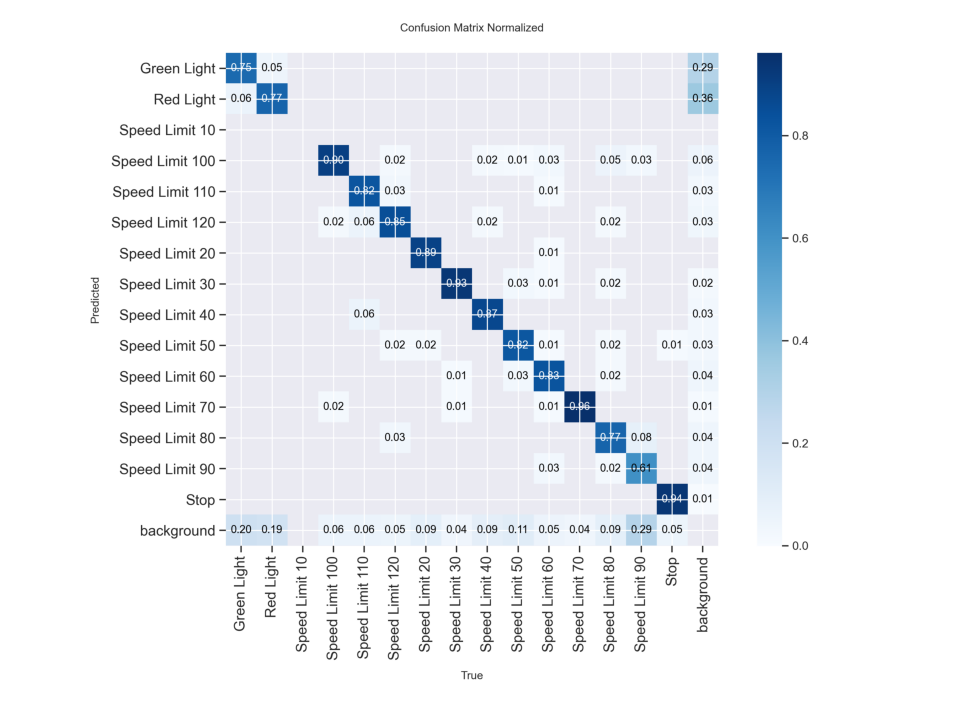

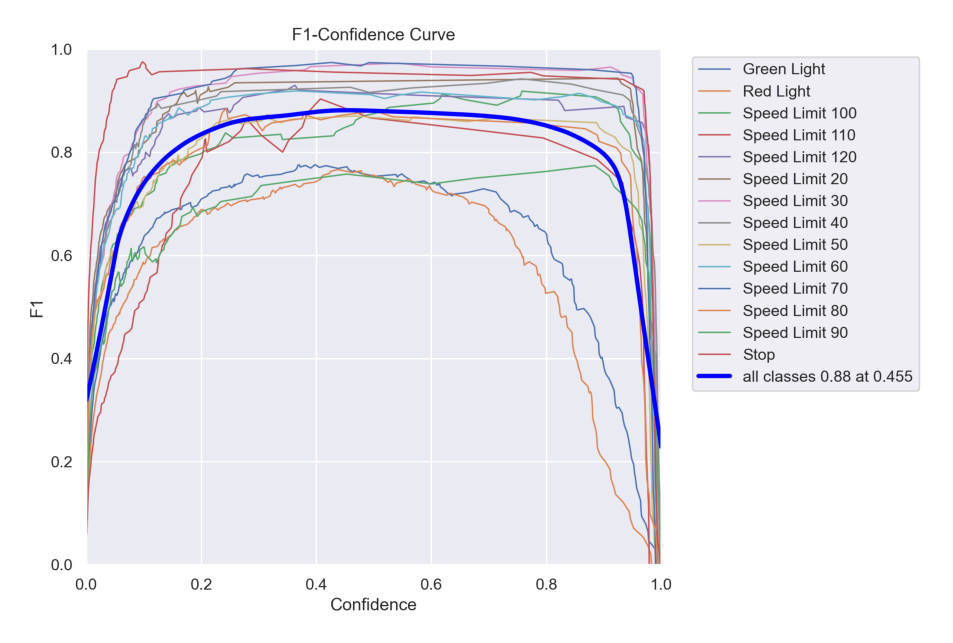

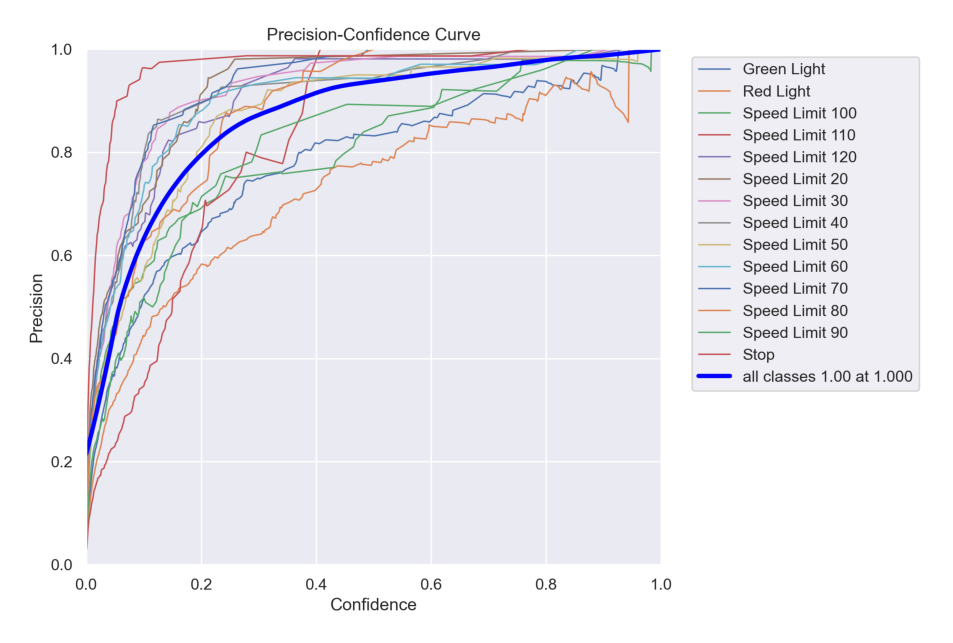

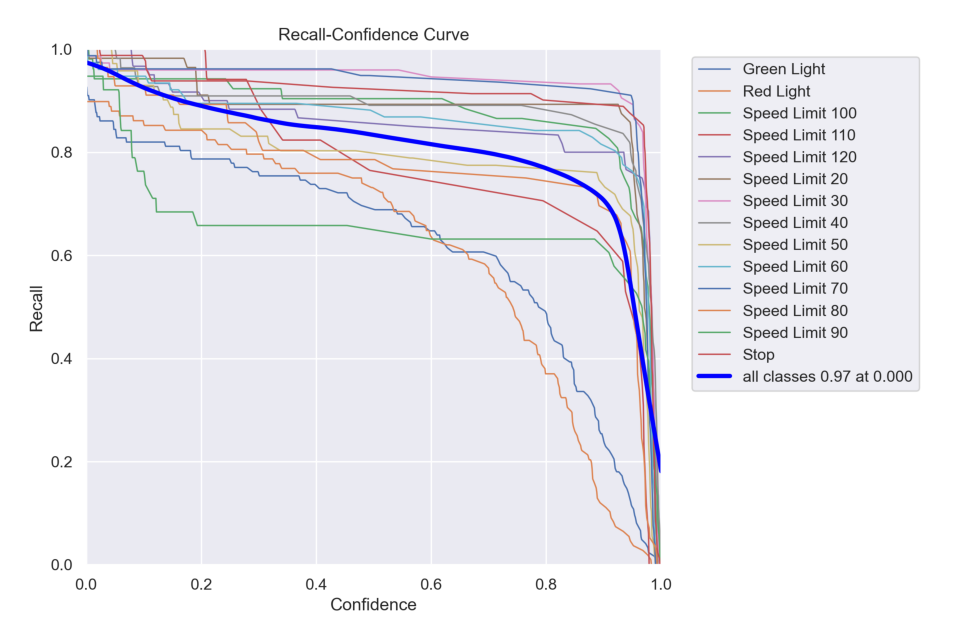

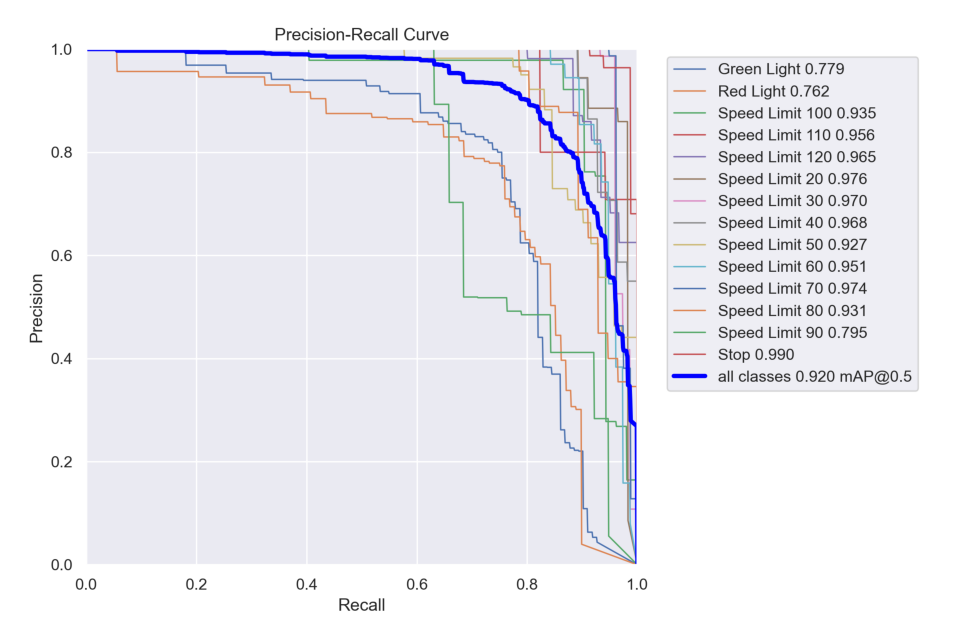

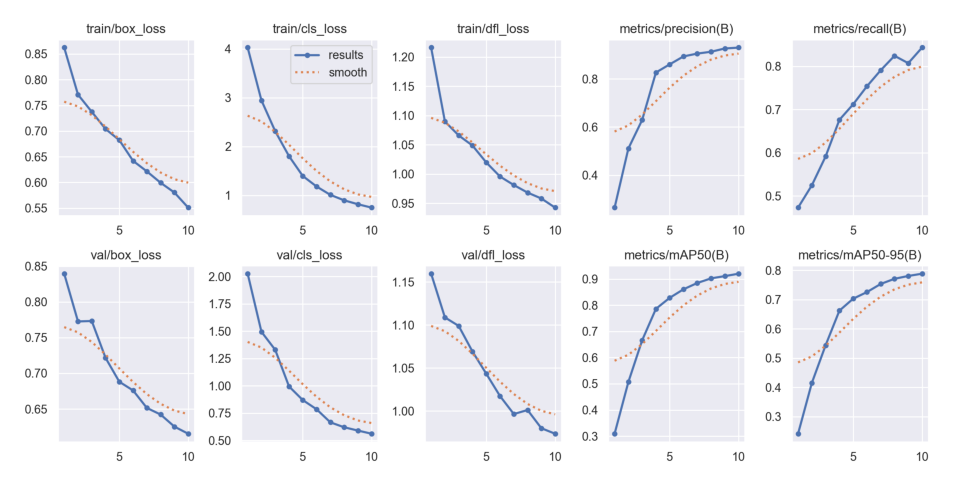

In [17]:

def display_images(post_training_files_path, image_files):

    for image_file in image_files:
        image_path = os.path.join(post_training_files_path, image_file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(10, 10), dpi=120)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# List of image files to display
image_files = [
    'confusion_matrix_normalized.png',
    'F1_curve.png',
    'P_curve.png',
    'R_curve.png',
    'PR_curve.png',
    'results.png'
]

# Path to the directory containing the images
post_training_files_path = os.path.join((os.getcwd()),"runs","detect","train")

# Display the images
display_images(post_training_files_path, image_files)


In [18]:
Result_Final_model = pd.read_csv(os.path.join((os.getcwd()),"runs","detect","train","results.csv"))
Result_Final_model.tail(10)

epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   82.6866         0.86246         4.02683         1.21622   
1      2  133.6700         0.77092         2.94527         1.08987   
2      3  184.0350         0.73741         2.31312         1.06605   
3      4  233.8290         0.70400         1.80365         1.04876   
4      5  284.0120         0.68220         1.39688         1.01990   
5      6  334.8940         0.64183         1.18160         0.99576   
6      7  385.7650         0.62140         1.01062         0.98125   
7      8  436.2870         0.59918         0.89866         0.96829   
8      9  486.8810         0.58022         0.81817         0.95820   
9     10  537.2980         0.55081         0.74858         0.94258   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.26475            0.47292           0.30917   
1               0.51066            0.52457           0.50677   
2               0.62934            0.59145           0.66579   
3               0.82676            0.67613           0.78601   
4               0.86069            0.71214           0.82799   
5               0.89372            0.75384           0.86054   
6               0.90538            0.79097           0.88457   
7               0.91305            0.82439           0.90221   
8               0.92669            0.80731           0.91084   
9               0.93032            0.84338           0.92002   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.24152       0.83958       2.02574       1.15958  0.000175   
1              0.41495       0.77268       1.49410       1.10875  0.000315   
2              0.54377       0.77329       1.32907       1.09884  0.000421   
3              0.66190       0.72166       0.99441       1.06907  0.000370   
4              0.70281       0.68814       0.86958       1.04331  0.000318   
5              0.72537       0.67595       0.78543       1.01726  0.000266   
6              0.75315       0.65146       0.66595       0.99639  0.000214   
7              0.77073       0.64217       0.62078       1.00101  0.000161   
8              0.78045       0.62526       0.59056       0.97989  0.000109   
9              0.78813       0.61529       0.56143       0.97345  0.000057   

     lr/pg1    lr/pg2  
0  0.000175  0.000175  
1  0.000315  0.000315  
2  0.000421  0.000421  
3  0.000370  0.000370  
4  0.000318  0.000318  
5  0.000266  0.000266  
6  0.000214  0.000214  
7  0.000161  0.000161  
8  0.000109  0.000109  
9  0.000057  0.000057

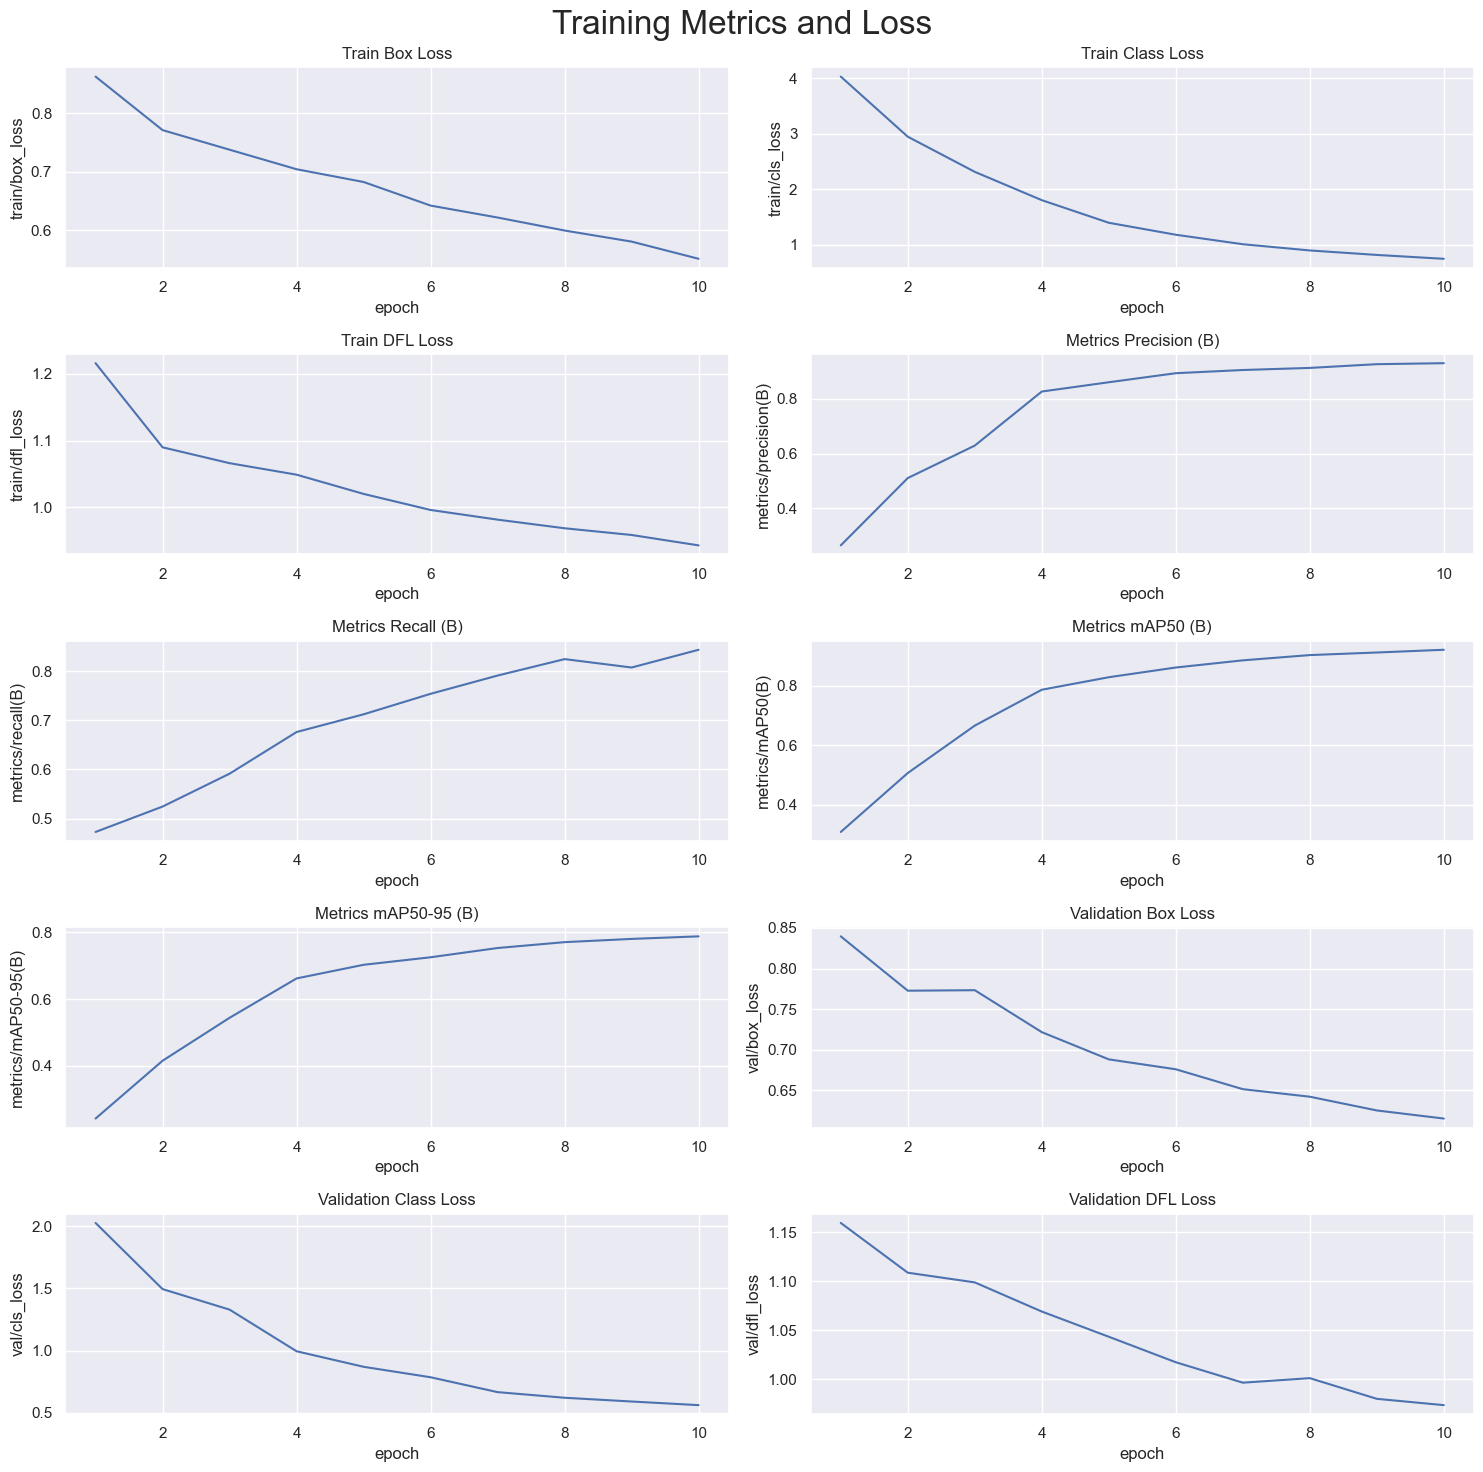

In [19]:
# Read the results.csv file as a pandas dataframe
Result_Final_model.columns = Result_Final_model.columns.str.strip()

# Create subplots
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# Plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=Result_Final_model, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=Result_Final_model, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=Result_Final_model, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=Result_Final_model, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=Result_Final_model, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=Result_Final_model, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=Result_Final_model, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=Result_Final_model, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=Result_Final_model, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=Result_Final_model, ax=axs[4,1])

# Set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')


plt.suptitle('Training Metrics and Loss', fontsize=24)
plt.subplots_adjust(top=0.8)
plt.tight_layout()
plt.show()

## Model Validation with Test Set

In [20]:
# Loading the best performing model
Valid_model = YOLO(os.path.join((os.getcwd()),"runs","detect","train","weights","best.pt"))

# Evaluating the model on the validset
metrics = Valid_model.val(split = 'val')

# final results 
print("precision(B): ", metrics.results_dict["metrics/precision(B)"])
print("metrics/recall(B): ", metrics.results_dict["metrics/recall(B)"])
print("metrics/mAP50(B): ", metrics.results_dict["metrics/mAP50(B)"])
print("metrics/mAP50-95(B): ", metrics.results_dict["metrics/mAP50-95(B)"])

Ultralytics 8.3.151  Python-3.11.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 27.59.9 MB/s, size: 11.2 KB)


val: Scanning C:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\data\valid\labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 51/51 [00:07<00:00,  6.56it/s]


                   all        801        944       0.93      0.843       0.92      0.788
           Green Light         87        122      0.829      0.715       0.78      0.442
             Red Light         74        108      0.765      0.753      0.762       0.43
       Speed Limit 100         52         52      0.799      0.904      0.935      0.861
       Speed Limit 110         17         17          1      0.791      0.956      0.848
       Speed Limit 120         60         60      0.981      0.859      0.965      0.878
        Speed Limit 20         56         56      0.986      0.893      0.976      0.847
        Speed Limit 30         71         74      0.978      0.959       0.97      0.898
        Speed Limit 40         53         55      0.943      0.909      0.968      0.855
        Speed Limit 50         68         71      0.947      0.803      0.927      0.833
        Speed Limit 60         76         76      0.944      0.886      0.951      0.861
        Speed Limit 7

## Predictions on Test Images


0: 640x640 1 Speed Limit 30, 27.8ms
Speed: 4.8ms preprocess, 27.8ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 30, 28.5ms
Speed: 5.3ms preprocess, 28.5ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Speed Limit 70, 8.0ms
Speed: 3.3ms preprocess, 8.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Stop, 12.5ms
Speed: 2.8ms preprocess, 12.5ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Speed Limit 70s, 10.0ms
Speed: 4.8ms preprocess, 10.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Green Lights, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Red Light, 11.8ms
Speed: 4.9ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Green Light, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 1.7ms p

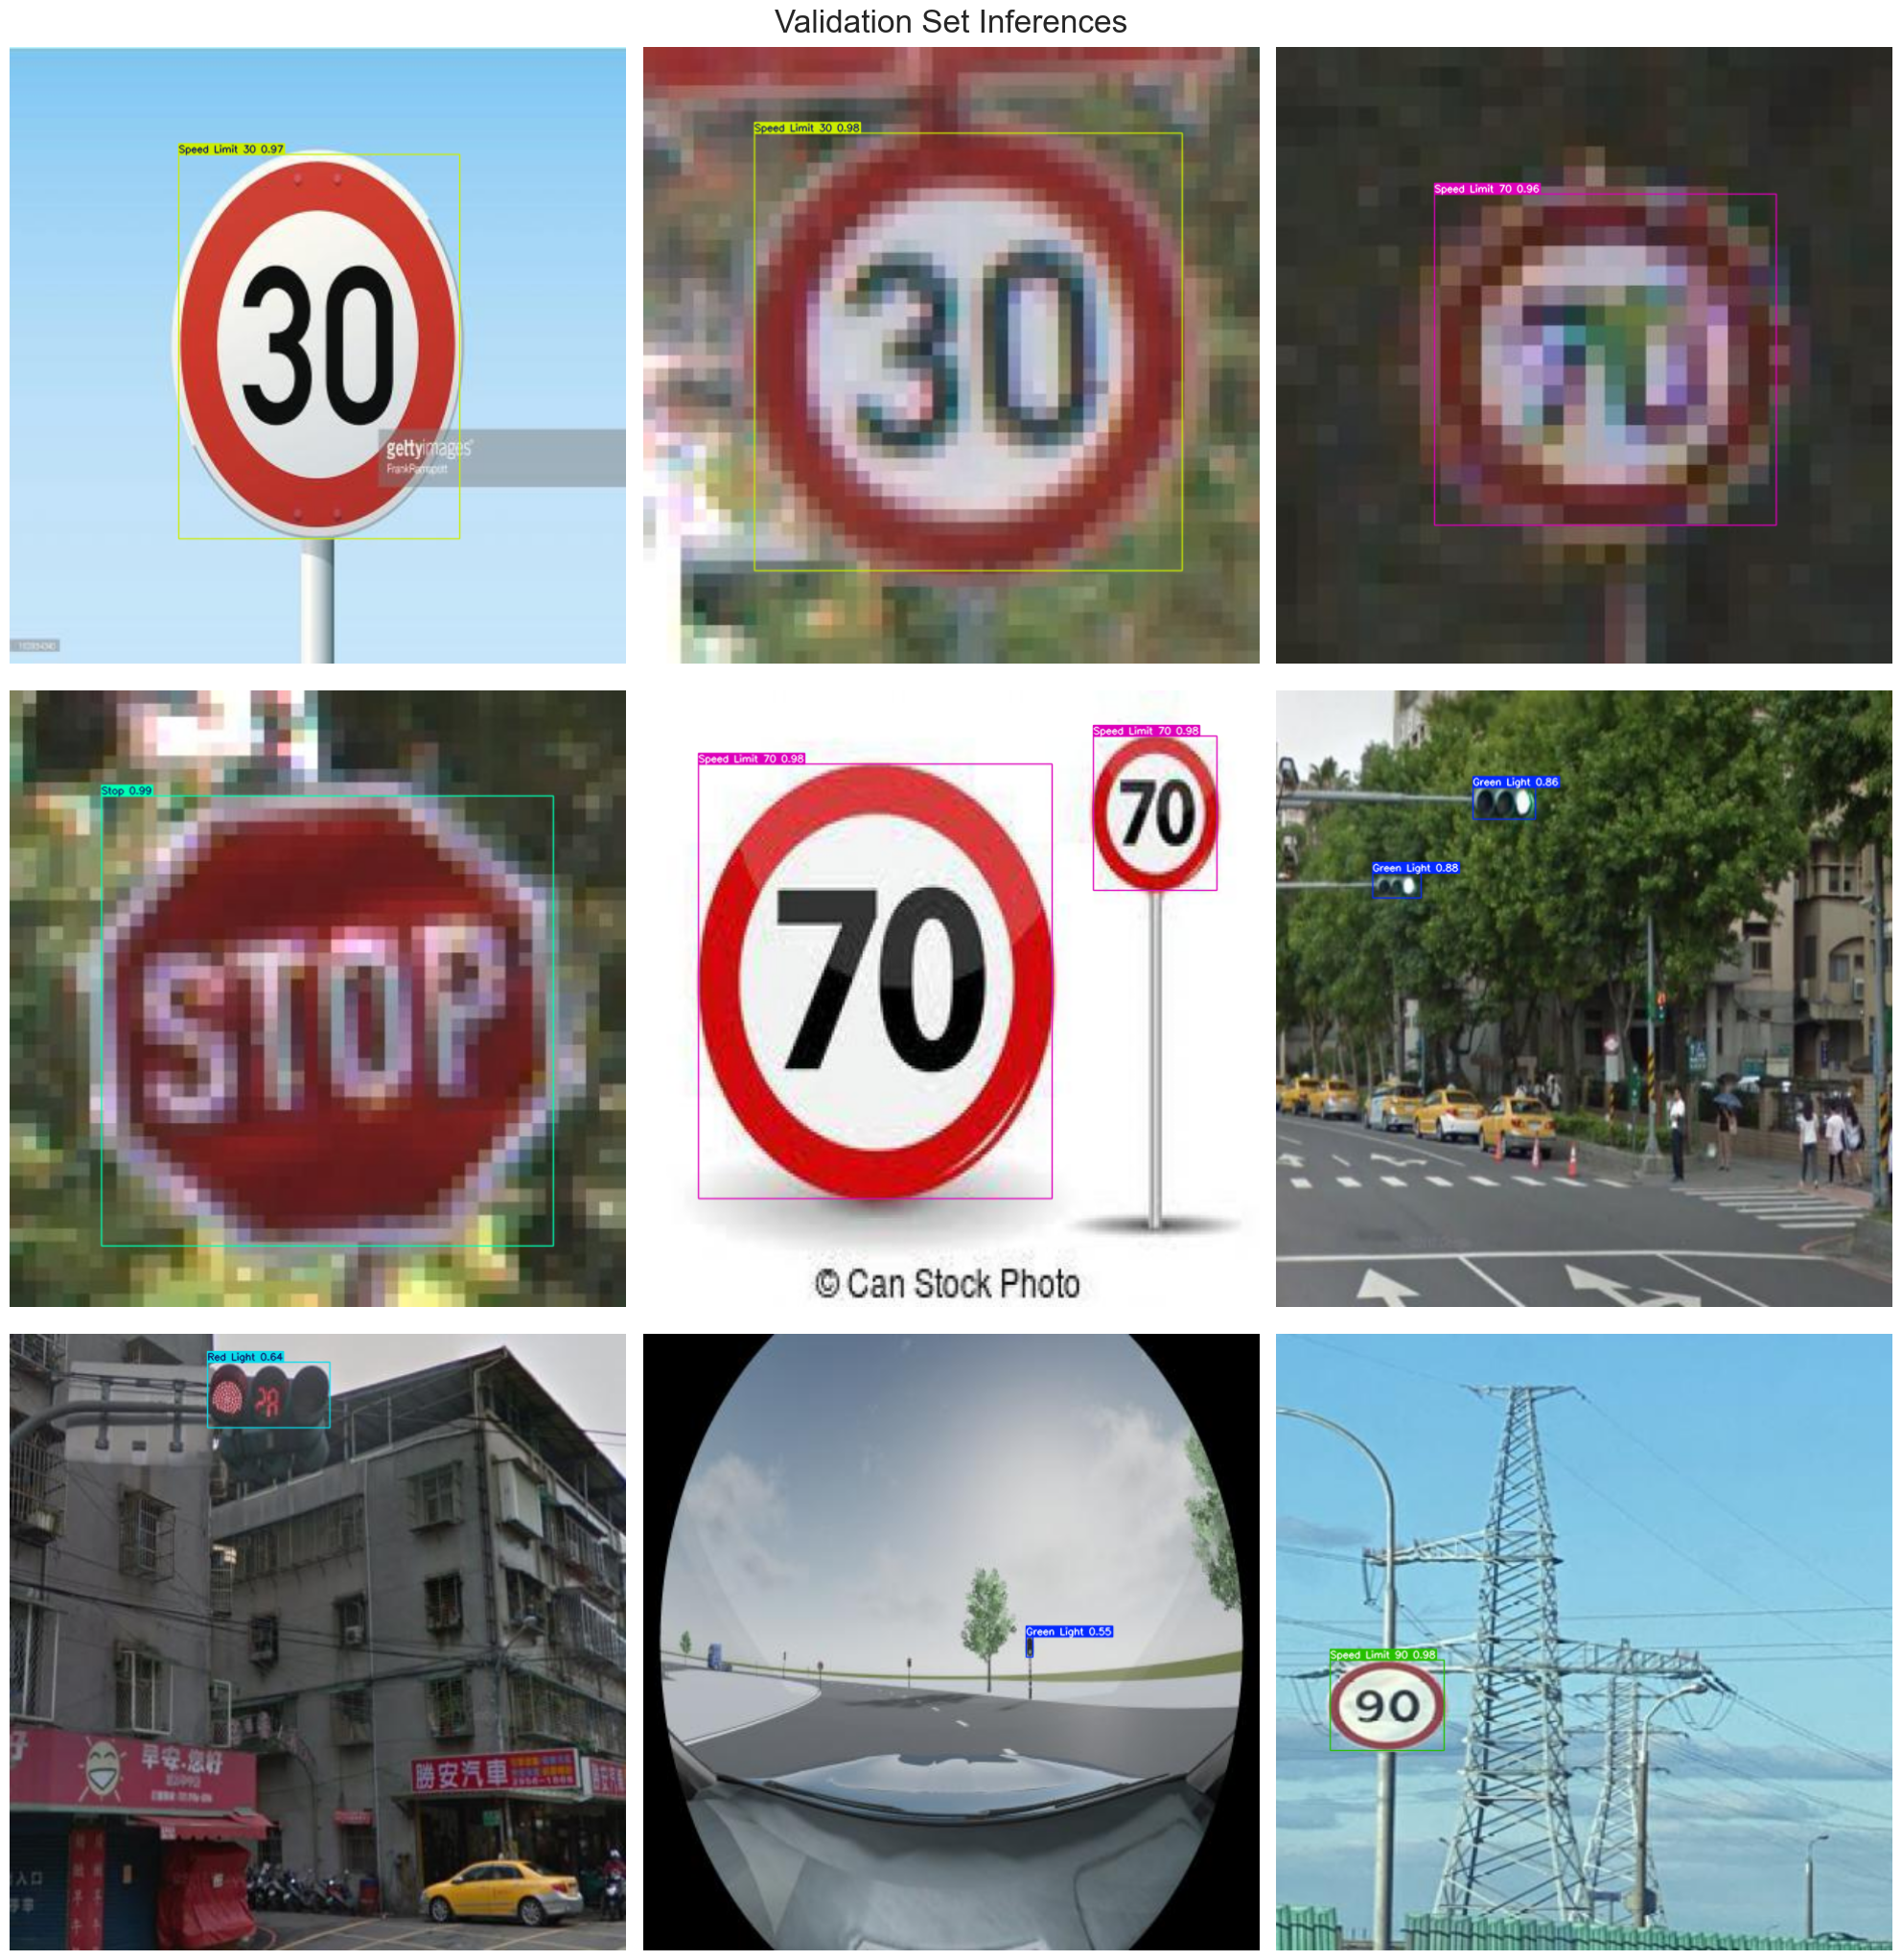

In [21]:
# Normalization function
def normalize_image(image):
    return image / 255.0

# Image resizing function
def resize_image(image, size=(640, 640)):
    return cv2.resize(image, size)

# Path to validation images
dataset_path = os.path.join(os.getcwd(), 'data')  # Place your dataset path here
valid_images_path = os.path.join(dataset_path, 'test', 'images')

# List of all jpg images in the directory
image_files = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]

# Check if there are images in the directory
if len(image_files) > 0:
    # Select 9 images at equal intervals
    num_images = len(image_files)
    step_size = max(1, num_images // 9)  # Ensure the interval is at least 1
    selected_images = [image_files[i] for i in range(0, num_images, step_size)]

    # Prepare subplots
    fig, axes = plt.subplots(3, 3, figsize=(20, 21))
    fig.suptitle('Validation Set Inferences', fontsize=24)

    for i, ax in enumerate(axes.flatten()):
        if i < len(selected_images):
            image_path = os.path.join(valid_images_path, selected_images[i])
            
            # Load image
            image = cv2.imread(image_path)
            
            # Check if the image is loaded correctly
            if image is not None:
                # Resize image
                resized_image = resize_image(image, size=(640, 640))
                # Normalize image
                normalized_image = normalize_image(resized_image)
                
                # Convert the normalized image to uint8 data type
                normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)
                
                # Predict with the model
                results = Valid_model.predict(source=normalized_image_uint8, imgsz=640, conf=0.5)
                
                # Plot image with labels
                annotated_image = results[0].plot(line_width=1)
                annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
                ax.imshow(annotated_image_rgb)
            else:
                print(f"Failed to load image {image_path}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


## Pre-trained YOLOv8 

## Saving the model

In [22]:
# Export the model
Valid_model.export(format='onnx')

Ultralytics 8.3.151  Python-3.11.0 torch-2.5.1+cu121 CPU (12th Gen Intel Core(TM) i7-12650H)
 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'c:\Users\aleja\OneDrive\Escritorio\Term_3\High_Dimensional\term_poster\runs\detect\train\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 19, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.56', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ---------------------------------------- 14.5/14.5 MB 2.2 MB/s eta 0:00:00
   ---------------------------------------- 214.9/214.9 MB 1.3 MB/s eta 0:00:00
   ---------------------------------------- 7/7 [onnxruntime-gpu]

requirements: AutoUpdate success  253.8s
WARNING requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming wi

'c:\\Users\\aleja\\OneDrive\\Escritorio\\Term_3\\High_Dimensional\\term_poster\\runs\\detect\\train\\weights\\best.onnx'